In [1]:
import pandas as pd
import numpy as np
import swifter
import scipy.stats as ss
import pingouin as pg

from gvs_ab import gvs_ab as ab

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Задача

Эксперимент проходил с 2024-03-01 по 2024-03-07 включительно.
- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?


# Решение

In [2]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240320'
}
db='simulator_20240320'

In [3]:
date_start = "toDate('2024-03-01')"
date_end = "toDate('2024-03-07')"

q = f"""
WITH 
filtered_data AS (
    SELECT
        user_id,
        time,
        exp_group,
        action
    FROM {db}.feed_actions
    WHERE 
        time>={date_start} AND time<{date_end}+1
),
feed_actions AS (
    -- Активность пользователей из интересующих групп за указанный период
    SELECT
      user_id,
      exp_group,
      countIf(time, action='like') AS likes,
      countIf(time, action='view') AS views,
      likes/views AS ctr
    FROM filtered_data
    GROUP BY user_id, exp_group
)

SELECT *
FROM feed_actions
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df

,user_id,exp_group,likes,views,ctr
0,18392,1,7,32,0.218750
1,115383,3,12,44,0.272727
2,123580,3,2,11,0.181818
3,131473,2,9,108,0.083333
4,107323,4,5,31,0.161290
...,...,...,...,...,...
49809,27030,0,12,64,0.187500
49810,122758,3,20,118,0.169492
49811,132567,1,52,326,0.159509
49812,122190,3,19,65,0.292308


## Группы 0 и 3

In [4]:
target_groups = (0, 3)

a = df.query(f'exp_group == {target_groups[0]}')
b = df.query(f'exp_group == {target_groups[1]}')

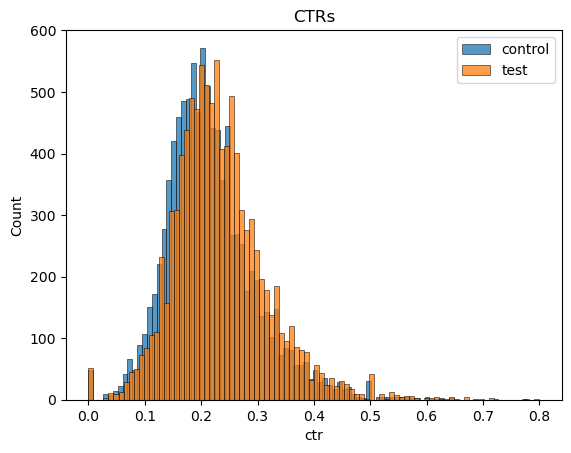

In [5]:
sns.histplot(a.ctr, label='control');
sns.histplot(b.ctr, label='test');
plt.legend();
plt.title('CTRs');

Чисто визуально кажется, что ctr увеличился

In [6]:
a.describe()

,user_id,exp_group,likes,views,ctr
count,9920.000000,9920.0,9920.000000,9920.000000,9920.000000
mean,76793.330444,0.0,14.184879,67.599194,0.216858
std,53094.372945,0.0,10.099360,45.894515,0.081514
min,201.000000,0.0,0.000000,1.000000,0.000000
25%,22408.500000,0.0,6.000000,32.000000,0.163636
50%,109906.000000,0.0,12.000000,58.000000,0.205357
75%,126744.000000,0.0,20.000000,93.000000,0.257143
max,140058.000000,0.0,80.000000,336.000000,0.777778


In [7]:
b.describe()

,user_id,exp_group,likes,views,ctr
count,10002.000000,10002.0,10002.000000,10002.000000,10002.000000
mean,75434.659368,3.0,15.129674,66.884123,0.233192
std,53259.926879,0.0,10.573216,45.234054,0.083925
min,200.000000,3.0,0.000000,1.000000,0.000000
25%,22006.500000,3.0,7.000000,32.000000,0.179688
50%,109298.000000,3.0,13.000000,57.000000,0.222222
75%,126137.250000,3.0,21.000000,91.000000,0.275862
max,140806.000000,3.0,89.000000,359.000000,0.800000


Поквантильно ctr увеличился

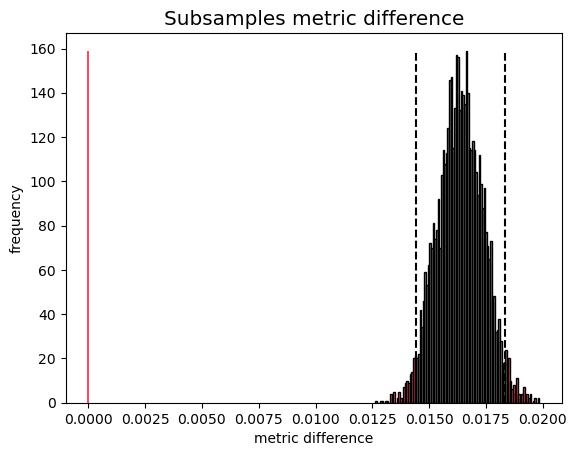

In [8]:
_ = ab.poisson_bootstrap_ctr(a.likes, a.views, b.likes, b.views)

=> имеются статзначимые отличия. В контрольной выборке ctr выше

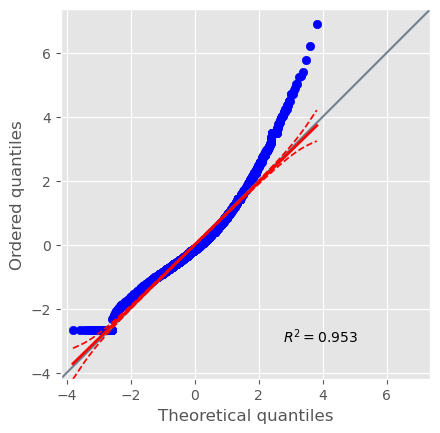

In [9]:
pg.qqplot(a.ctr);

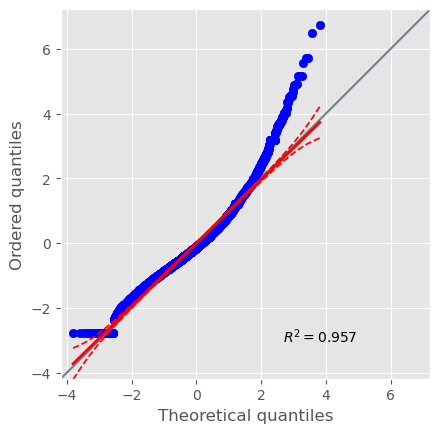

In [10]:
pg.qqplot(b.ctr);

Распределения похожи на нормальные, для сравнения с линеаризованной версией можно использовать t-test

*Для начала было бы лучше использовать сглаживание или бакетизацию, но для чистоты эксперимента этот момент опустим

In [11]:
ss.levene(a.ctr, b.ctr)

LeveneResult(statistic=5.031261726895545, pvalue=0.024904704904358744)

In [12]:
ss.ttest_ind(a.ctr, b.ctr, equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

In [13]:
# Линеаризация
a_likes_lin, b_likes_lin = ab.linearization_ratio(a.likes, a.views, b.likes, b.views)

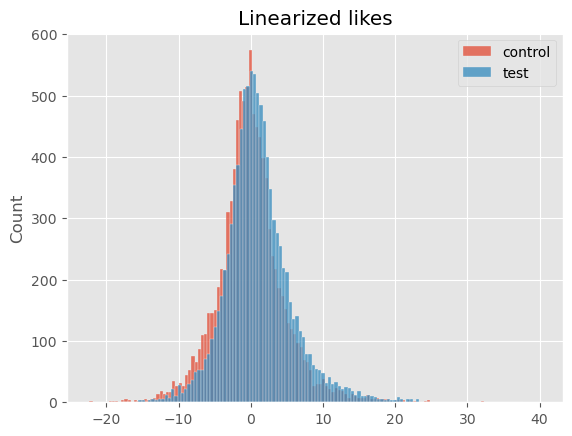

In [14]:
sns.histplot(a_likes_lin, label='control');
sns.histplot(b_likes_lin, label='test');
plt.legend();
plt.title('Linearized likes');

In [15]:
ss.levene(a_likes_lin, b_likes_lin)

LeveneResult(statistic=0.13576527402423189, pvalue=0.7125316496454377)

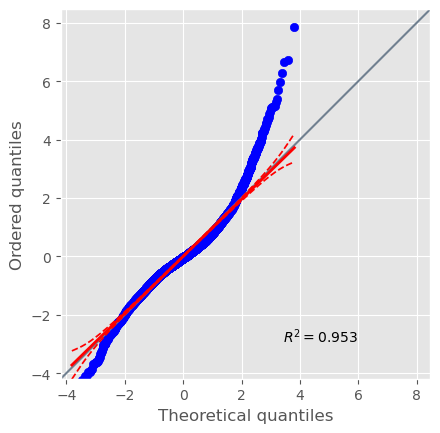

In [16]:
pg.qqplot(a_likes_lin);

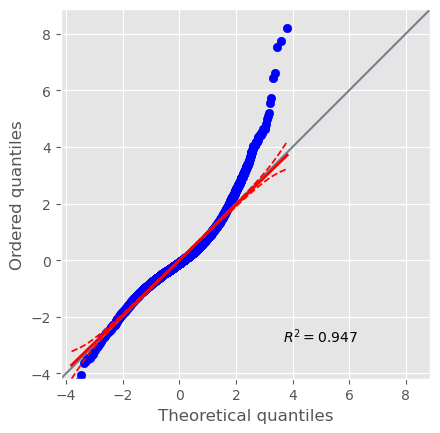

In [17]:
pg.qqplot(b_likes_lin);

Кажется, что условия для применения t-теста довольно хорошие

*При этом тест можно использовать без поправки Уэлча (в силу однородности дисперсий) - для повышения чувствительности. Но опустим этот момент для чистоты эксперимента

In [18]:
ss.ttest_ind(a_likes_lin, b_likes_lin, equal_var=False)

Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

p-value стал ещё меньше, что свидетельствует о лучшем детектировании различий таким образом

#### Выводы
- между группами 0 и 3 имеются статзначимые отличия
- CTR в тестовой групе больше
- линеаризация лайков повышает чувствительность метрики (по сравнению с поюзерным CTR)

-----------------------
## Группы 1 и 2

In [19]:
target_groups = (1, 2)

a = df.query(f'exp_group == {target_groups[0]}')
b = df.query(f'exp_group == {target_groups[1]}')

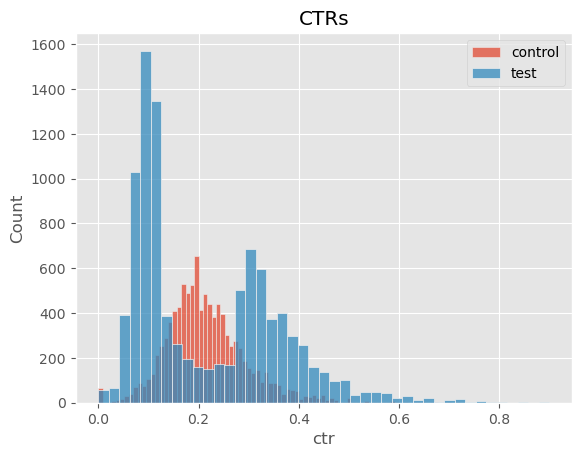

In [20]:
sns.histplot(a.ctr, label='control');
sns.histplot(b.ctr, label='test');
plt.legend();
plt.title('CTRs');

Тестовая группа некрасивая, t-test на ней в явном виде лучше не использовать

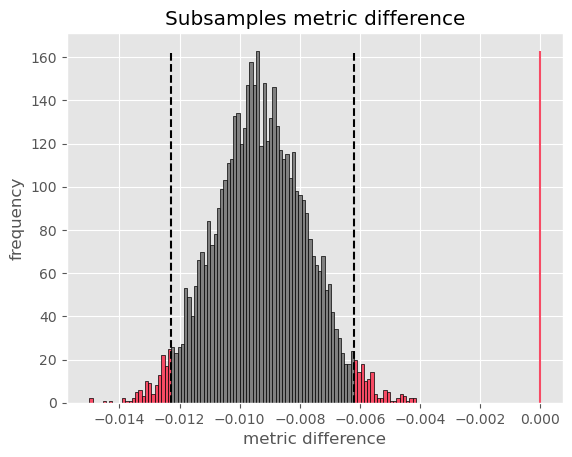

In [21]:
_ = ab.poisson_bootstrap_ctr(a.likes, a.views, b.likes, b.views)

=> имеются статзначимые отличия. В контрольной выборке ctr ниже

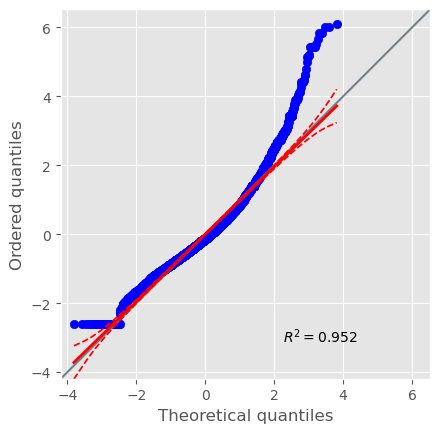

In [22]:
pg.qqplot(a.ctr);

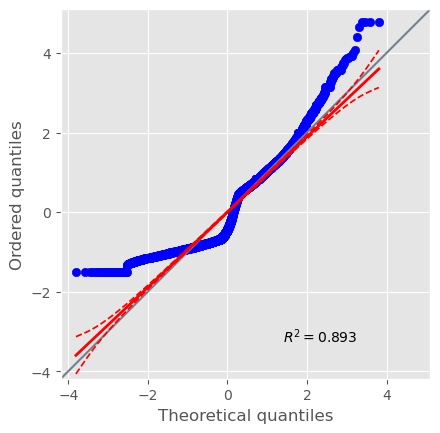

In [23]:
pg.qqplot(b.ctr);

In [30]:
ss.levene(a.ctr, b.ctr)

LeveneResult(statistic=2757.7940649593243, pvalue=0.0)

In [24]:
ss.ttest_ind(a.ctr, b.ctr, equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

=> статзначимые отличия не обнаружены

In [25]:
# Линеаризация
a_likes_lin, b_likes_lin = ab.linearization_ratio(a.likes, a.views, b.likes, b.views)

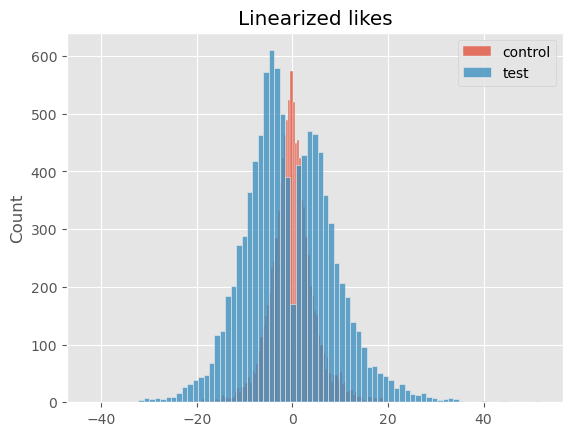

In [26]:
sns.histplot(a_likes_lin, label='control');
sns.histplot(b_likes_lin, label='test');
plt.legend();
plt.title('Linearized likes');

In [27]:
ss.levene(a_likes_lin, b_likes_lin)

LeveneResult(statistic=3535.1569451708956, pvalue=0.0)

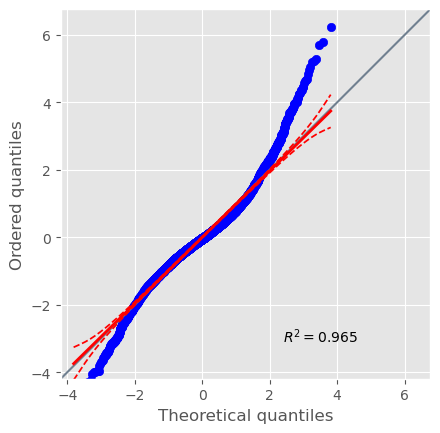

In [28]:
pg.qqplot(a_likes_lin);

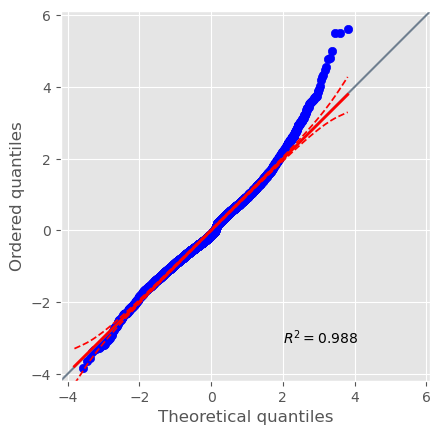

In [29]:
pg.qqplot(b_likes_lin);

Кажется, что условия для применения t-теста улучшились

In [31]:
ss.ttest_ind(a_likes_lin, b_likes_lin, equal_var=False)

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

t-test заработал!

#### Выводы
- между группами 1 и 2 имеются статзначимые отличия
- CTR в тестовой групе меньше
- линеаризация лайков повышает чувствительность метрики (по сравнению с поюзерным CTR)

---------------------------------------
# Общие выводы
- указанные тесты прокрасиились
- линеаризация лайков повышает чувствительность метрики (по сравнению с CTR)

Inspired by: KCSDA_AB_linearization